In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import statistics
from sklearn.metrics import mean_squared_log_error, mean_squared_error


from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor



pd.set_option('display.max_columns', 500)

In [2]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
run_cells = 1

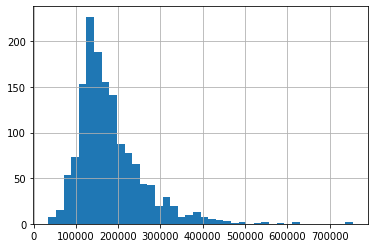

In [9]:
train_df['SalePrice'].hist(bins = 40)

In [3]:
if run_cells == 1:
    train_df.loc[train_df['Condition2'] != 'Norm', 'Condition2'] = 1
    train_df.loc[train_df['Condition2'] == 'Norm', 'Condition2'] = 0
    train_df.loc[train_df['SaleType'] != 'New', 'SaleType'] = 0
    train_df.loc[train_df['SaleType'] == 'New', 'SaleType'] = 1
    test_df.loc[test_df['Condition2'] != 'Norm', 'Condition2'] = 1
    test_df.loc[test_df['Condition2'] == 'Norm', 'Condition2'] = 0
    test_df.loc[test_df['SaleType'] != 'New', 'SaleType'] = 0
    test_df.loc[test_df['SaleType'] == 'New', 'SaleType'] = 1
    train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
    run_cells = 0

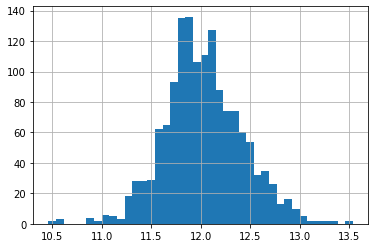

In [11]:
train_df['SalePrice'].hist(bins = 40)

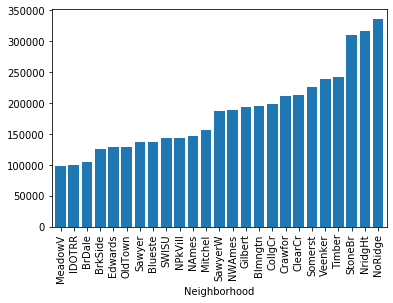

In [7]:
train_df.groupby('Neighborhood')['SalePrice'].mean().sort_values().plot(kind='bar',width=0.8)

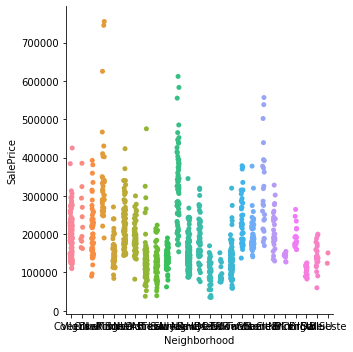

In [8]:
sns.catplot(x="Neighborhood", y="SalePrice", data=train_df)

In [90]:
# ExterQual, Condition1, Neighborhood, MSZoning, CentralAir, MasVnrType, LandContour, LotShape
train_df_small = train_df.loc[:,['ExterQual', 'Condition1', 'Condition2','SaleType', 'Neighborhood', 'MSZoning', 'CentralAir', 'MasVnrType', 'LandContour', 'LotShape', 'FireplaceQu', 'OverallQual', 'OverallCond', 'YearBuilt', 'LotFrontage', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'OpenPorchSF', 'GarageCars', 'LotArea']]
train_df_small = pd.get_dummies(train_df_small)
test_df_small = test_df.loc[:,['ExterQual', 'Condition1', 'Condition2','SaleType', 'Neighborhood', 'MSZoning', 'CentralAir', 'MasVnrType', 'LandContour', 'LotShape', 'FireplaceQu', 'OverallQual', 'OverallCond', 'YearBuilt', 'LotFrontage', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'OpenPorchSF', 'GarageCars', 'LotArea']]
test_df_small = pd.get_dummies(test_df_small)
#OverallQual, OverallCond, YearBuilt, LotFrontage, TotalBsmtSF, 1stFlrSF, GrLivArea, TotRmsAbvGrd, OpenPorchSF, GarageCars, LotArea
train_df_small.describe()


,Condition2,SaleType,OverallQual,OverallCond,YearBuilt,LotFrontage,TotalBsmtSF,1stFlrSF,GrLivArea,TotRmsAbvGrd,OpenPorchSF,GarageCars,LotArea,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,CentralAir_N,CentralAir_Y,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.010274,0.083562,6.099315,5.575342,1971.267808,70.049958,1057.429452,1162.626712,1515.463699,6.517808,46.660274,1.767123,10516.828082,0.035616,0.009589,0.334247,0.620548,0.032877,0.055479,0.863014,0.005479,0.013014,0.007534,0.017808,0.001370,0.003425,0.011644,0.001370,0.010959,0.039726,0.019178,0.102740,0.034932,0.068493,0.054110,0.025342,0.011644,0.033562,0.154110,0.006164,0.05000,0.028082,0.05274,0.077397,0.017123,0.050685,0.040411,0.058904,0.017123,0.026027,0.007534,0.006849,0.044521,0.010959,0.788356,0.149315,0.065068,0.934932,0.010274,0.304795,0.591781,0.087671,0.043151,0.034247,0.024658,0.897945,0.331507,0.028082,0.006849,0.633562,0.016438,0.022603,0.260274,0.013699,0.214384
std,0.100873,0.276824,1.382997,1.112799,30.202904,24.284752,438.705324,386.587738,525.480383,1.625393,66.256028,0.747315,9981.264932,0.185395,0.097486,0.471888,0.485417,0.178375,0.228992,0.343951,0.073846,0.113372,0.086502,0.132299,0.036999,0.058440,0.107313,0.036999,0.104145,0.195382,0.137198,0.303723,0.183669,0.252677,0.226311,0.157217,0.107313,0.180160,0.361177,0.078298,0.21802,0.165264,0.22359,0.267312,0.129775,0.219429,0.196989,0.235526,0.129775,0.159271,0.086502,0.082505,0.206319,0.104145,0.408614,0.356521,0.246731,0.246731,0.100873,0.460478,0.491673,0.282913,0.203266,0.181924,0.155132,0.302824,0.470916,0.165264,0.082505,0.481996,0.127198,0.148684,0.438934,0.116277,0.410535
min,0.000000,0.000000,1.000000,1.000000,1872.000000,21.000000,0.000000,334.000000,334.000000,2.000000,0.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [49]:
impute = IterativeImputer(random_state=0)
impute.fit(train_df_small)
train_df_small_imputed = pd.DataFrame(impute.transform(train_df_small), columns=train_df_small.columns)

In [92]:
scaler = StandardScaler()
scaler.fit(train_df_small_imputed)
train_df_small_scaled = pd.DataFrame(scaler.transform(train_df_small_imputed), columns=train_df_small_imputed.columns)
train_df_small_scaled.describe()

,Condition2,SaleType,OverallQual,OverallCond,YearBuilt,LotFrontage,TotalBsmtSF,1stFlrSF,GrLivArea,TotRmsAbvGrd,OpenPorchSF,GarageCars,LotArea,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,CentralAir_N,CentralAir_Y,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,-2.194211e-16,-3.406712e-16,-7.680310e-17,3.692632e-16,1.032983e-15,3.093796e-16,2.063038e-16,7.686013e-17,-1.446332e-16,4.387662e-17,3.357284e-17,2.585451e-17,-4.202783e-17,4.903992e-16,-8.235421e-17,1.907150e-16,1.805253e-16,-1.972167e-16,-5.608527e-16,-1.541385e-16,4.729854e-17,6.438913e-17,2.375573e-16,-1.785482e-16,-2.786964e-16,-8.830455e-18,-2.689059e-16,-1.041785e-17,1.726739e-16,2.194211e-16,2.124252e-16,-9.208768e-17,2.489637e-16,1.441769e-16,-1.578266e-16,-6.949920e-16,-1.477129e-16,8.486362e-17,-6.045392e-17,1.712481e-16,9.323972e-16,-3.432946e-16,9.784031e-16,-4.170180e-16,3.068702e-16,2.848939e-16,2.505986e-16,-2.524617e-17,2.363026e-16,-3.177443e-16,2.691911e-16,5.355305e-17,6.421804e-17,-4.176644e-17,-1.344434e-16,-4.710844e-16,-1.131515e-16,2.494960e-16,3.119651e-17,1.463061e-16,-1.350518e-16,-1.551271e-16,-2.735255e-16,1.039884e-16,4.413897e-16,1.304132e-16,-9.383666e-17,-2.797230e-16,3.200066e-16,-3.450816e-16,4.258390e-18,-5.342758e-16,-5.170902e-17,-1.314207e-16,-2.100299e-16
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e

In [83]:
x = train_df_small_scaled
y = train_df.loc[:, ['SalePrice']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.3)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size=0.3)
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y, test_size=0.3)
x_train5, x_test5, y_train5, y_test5 = train_test_split(x, y, test_size=0.3)

In [121]:
params = {'min_child_weight':[4,5]
          ,'gamma':[i/10.0 for i in range(3,6)]
          ,'subsample':[i/10.0 for i in range(6,11)]
          ,'colsample_bytree':[i/10.0 for i in range(6,11)]
          ,'max_depth': [2,3,4]}

In [ ]:
# model = XGBRegressor()
# grid = RandomizedSearchCV(model, params)
# grid.fit(x_train, np.asarray(y_train))
# output = grid.best_estimator_.predict(x_test)

In [124]:
model = XGBRegressor()
model2 = XGBRegressor()
model3 = XGBRegressor()
model4 = XGBRegressor()
model5 = XGBRegressor()

grid = RandomizedSearchCV(model, params)
grid2 = RandomizedSearchCV(model2, params)
grid3 = RandomizedSearchCV(model3, params)
grid4 = RandomizedSearchCV(model4, params)
grid5 = RandomizedSearchCV(model5, params)

In [125]:
grid.fit(x_train, np.asarray(y_train))
grid2.fit(x_train2, np.asarray(y_train2))
grid3.fit(x_train3, np.asarray(y_train3))
grid4.fit(x_train4, np.asarray(y_train4))
grid5.fit(x_train5, np.asarray(y_train5))

C:\Users\zack.coleman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[00:06:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\zack.coleman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[00:06:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\zack.coleman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\zack.coleman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

C:\Users\zack.coleman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          rand...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [140]:
output = grid.best_estimator_.predict(x_test)
output2 = grid2.best_estimator_.predict(data=x_test2)
output3 = grid3.best_estimator_.predict(data=x_test3)
output4 = grid4.best_estimator_.predict(data=x_test4)
output5 = grid5.best_estimator_.predict(data=x_test5)

In [142]:
rmsle = np.sqrt(mean_squared_log_error(y_test, output))
rmsle2 = np.sqrt(mean_squared_log_error(y_test2, output2))
rmsle3 = np.sqrt(mean_squared_log_error(y_test3, output3))
rmsle4 = np.sqrt(mean_squared_log_error(y_test4, output4))
rmsle5 = np.sqrt(mean_squared_log_error(y_test5, output5))
print(statistics.median([rmsle, rmsle2, rmsle3, rmsle4, rmsle5]))

0.1365553772554111


In [131]:
impute.fit(test_df_small)
test_df_small_imputed = pd.DataFrame(impute.transform(test_df_small), columns=test_df_small.columns)

In [132]:
scaler.fit(test_df_small_imputed)
test_df_small_scaled = pd.DataFrame(scaler.transform(test_df_small_imputed), columns=test_df_small_imputed.columns)

In [133]:
test_output = pd.DataFrame(grid.best_estimator_.predict(data=test_df_small_scaled))
test_output2 = pd.DataFrame(grid2.best_estimator_.predict(data=test_df_small_scaled))
test_output3 = pd.DataFrame(grid3.best_estimator_.predict(data=test_df_small_scaled))
test_output4 = pd.DataFrame(grid4.best_estimator_.predict(data=test_df_small_scaled))
test_output5 = pd.DataFrame(grid5.best_estimator_.predict(data=test_df_small_scaled))

final_prediction = test_output * .2 + test_output2 * .2 + test_output3 * .2 + test_output4 * .2 + test_output5 * .2

In [134]:
output = pd.merge(test_df.loc[:,['Id']], pd.DataFrame(final_prediction), right_index=True, left_index=True)
output.columns = ['Id', 'SalePrice']
output.to_csv("outputXGTry1.csv", index=False)